<a href="https://colab.research.google.com/github/JosephAjayKarolAravindan/33.2/blob/master/Group11_DataCollection_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
from google.colab import drive
drive.mount ('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [149]:
!apt-get update #update linux
!apt-get install openjdk-8-jdk-headless -qq > /dev/null #download and install openjdk
!wget -q http://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz #download spark binary (gunzip)
!tar xf spark-3.2.1-bin-hadoop2.7.tgz #extract the spark package
!pip install -q findspark #install the findspark package

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-upda

In [150]:
#setting the environment variables
import os 
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [151]:
import findspark
findspark.init()
from pyspark import SparkContext

sc = SparkContext.getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [152]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("HDFS_Haversine_Fun").getOrCreate() 
spark

In [153]:
df_house.drop()
df_house_final2.drop()
df_house_final.drop()
df_house_new.drop()
df_houseclean.drop()

DataFrame[longitude: double, latitude: double, housing_median_age: int, total_rooms: int, total_bedrooms: int, population: int, households: int, median_income: double, median_house_value: int, ocean_proximity: string]

In [154]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [157]:
# import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 

# File location and type
path = '/content/gdrive/MyDrive/Data/housing.csv' 
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# Import csv. The applied options are for CSV files. For other file types, these will be ignored.
df_house = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(path)

df_house.show() #first row object

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|                41|        880|           129|       322|       126|       8.3252|            452600|       NEAR BAY|
|  -122.22|   37.86|                21|       7099|          1106|      2401|      1138|       8.3014|            358500|       NEAR BAY|
|  -122.24|   37.85|                52|       1467|           190|       496|       177|       7.2574|            352100|       NEAR BAY|
|  -122.25|   37.85|                52|       1274|           235|       558|       219|       5.6431|            341300|       NEAR BAY|
|  -122.25|   37.85|              

In [158]:
df_house.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: integer (nullable = true)
 |-- total_rooms: integer (nullable = true)
 |-- total_bedrooms: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- households: integer (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: integer (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [159]:
# convert all strings to float using a User Defined Function

from pyspark.sql.functions import col
from pyspark.sql.types import StringType,BooleanType,DateType,FloatType

df_house_new = df_house.withColumn("longitude",col("longitude").cast(FloatType())) \
   .withColumn("latitude",col("latitude").cast(FloatType())) \
   .withColumn("housing_median_age",col("housing_median_age").cast(FloatType())) \
   .withColumn("total_rooms",col("total_rooms").cast(FloatType())) \
   .withColumn("total_bedrooms",col("total_bedrooms").cast(FloatType())) \
   .withColumn("population",col("population").cast(FloatType())) \
   .withColumn("households",col("households").cast(FloatType())) \
   .withColumn("median_income",col("median_income").cast(FloatType())) \
   .withColumn("median_house_value",col("median_house_value").cast(FloatType()))

In [160]:
df_house_new.printSchema()
df_house_new.show(2)

root
 |-- longitude: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- housing_median_age: float (nullable = true)
 |-- total_rooms: float (nullable = true)
 |-- total_bedrooms: float (nullable = true)
 |-- population: float (nullable = true)
 |-- households: float (nullable = true)
 |-- median_income: float (nullable = true)
 |-- median_house_value: float (nullable = true)
 |-- ocean_proximity: string (nullable = true)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -1

In [161]:
df_house_new.describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|            20640|             20640|             20640|          20640|
|   mean|-119.56970444871473|35.63186143109965|28.639486434108527|2635.7630813953488| 537.8705525375618|1425.4767441860465|499.5396802325581|3.8706710030346416|206855.81690891474|           null|
| stddev|  2.0035317

# **Data Cleansing - removing null and blank values to get accurate predictions**

In [162]:
#display null values count for each column as part of data cleansing
from pyspark.sql.functions import isnan,when,count, col

df_house.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in df_house.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



In [167]:
#As total_bedrooms is an important attribute in predicting house price, dropping all rows if total_bedrooms is null
df_house=df_house.na.drop("all",subset=['total_bedrooms'])

#no null values in the dataframe
df_house.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in df_house.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+----------------+-----------------+----------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|medianHouseValue|roomsPerHousehold|populationPerHousehold|bedroomsPerRoom|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+----------------+-----------------+----------------------+---------------+
|        0|       0|                 0|          0|             0|         0|         0|            0|                 0|              0|               0|                0|                     0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+---------------

# **Adding Features**

Add more columns such as 'number of bedrooms per room', 'rooms per household'. Also scaling the 'medianHouseValue' by 1000 so it falls within range of other numbers.


In [168]:
from pyspark.sql.functions import col

df_house = df_house.withColumn('medianHouseValue', col('median_house_value')/100000)

# add rooms per household
df_house = df_house.withColumn('roomsPerHousehold', col('total_rooms')/col('households'))

# add population per household (num people in the home)
df_house = df_house.withColumn('populationPerHousehold', col('population')/col('households'))

# add bedrooms per room
df_house = df_house.withColumn('bedroomsPerRoom', col('total_bedrooms')/col('total_rooms'))

df_house.show(3)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+----------------+-----------------+----------------------+-------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|medianHouseValue|roomsPerHousehold|populationPerHousehold|    bedroomsPerRoom|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+----------------+-----------------+----------------------+-------------------+
|  -122.23|   37.88|                41|        880|           129|       322|       126|       8.3252|            452600|       NEAR BAY|           4.526|6.984126984126984|    2.5555555555555554|0.14659090909090908|
|  -122.22|   37.86|                21|       7099|          1106|      2401|      1138|       8.3014|            358500|       NEAR BAY

In [169]:
#Re-order columns and split table into label and features

df_house_final = df_house.select('medianHouseValue','households','housing_median_age','latitude','longitude',
 'median_income','population','total_bedrooms','total_rooms','roomsPerHousehold','populationPerHousehold','bedroomsPerRoom')

df_house_final.show(3)

+----------------+----------+------------------+--------+---------+-------------+----------+--------------+-----------+-----------------+----------------------+-------------------+
|medianHouseValue|households|housing_median_age|latitude|longitude|median_income|population|total_bedrooms|total_rooms|roomsPerHousehold|populationPerHousehold|    bedroomsPerRoom|
+----------------+----------+------------------+--------+---------+-------------+----------+--------------+-----------+-----------------+----------------------+-------------------+
|           4.526|       126|                41|   37.88|  -122.23|       8.3252|       322|           129|        880|6.984126984126984|    2.5555555555555554|0.14659090909090908|
|           3.585|      1138|                21|   37.86|  -122.22|       8.3014|      2401|          1106|       7099|6.238137082601054|     2.109841827768014|0.15579659106916466|
|           3.521|       177|                52|   37.85|  -122.24|       7.2574|       496|   

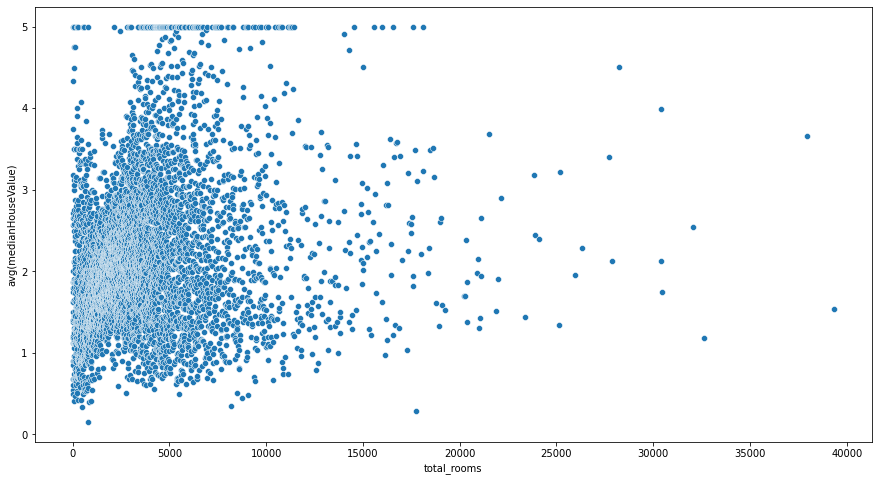

In [203]:
#Average price of house
import matplotlib.pyplot as plt
df1 = df_house.groupby('total_rooms').avg().sort('total_rooms').select(['total_rooms','avg(medianHouseValue)'])
df_p = df1.toPandas()
plt.figure(figsize = (15, 8))
sns.scatterplot(x = df_p['total_rooms'], y = df_p['avg(medianHouseValue)'] )

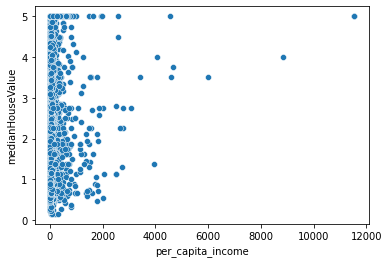

In [206]:
#Adding a column of per-capita income to the dataframe

df_house_per_capita = df_house.withColumn('per_capita_income', df_house['median_income']*10000/df_house['population'])

#Per-capita-income and prices of the home
df_p = df_house_per_capita.toPandas()
sns.scatterplot(x = df_p['per_capita_income'], y = df_p['medianHouseValue'])

In [207]:
df_house.select('ocean_proximity').distinct().show()

+---------------+
|ocean_proximity|
+---------------+
|         ISLAND|
|     NEAR OCEAN|
|       NEAR BAY|
|      <1H OCEAN|
|         INLAND|
+---------------+



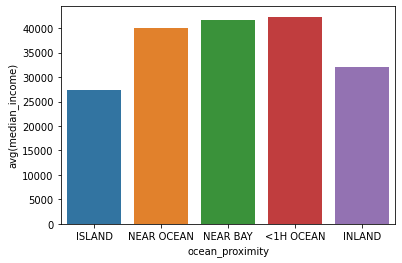

In [210]:
#Where does wealthy people live?
df_i = df_house.groupby('ocean_proximity').agg({'median_income' : 'avg'})
df_p = df_i.toPandas()
sns.barplot(x = df_p['ocean_proximity'], y = df_p['avg(median_income)']*10000)

In [170]:
#Creating a new DataFrame that explicitly labels the columns as labels and features. 
#DenseVector is used to temporarily convert the data into numpy array and regroup into a named column DataFrame

from pyspark.ml.linalg import DenseVector

# return a tuple of first column and all other columns
temp_data = df_house_final.rdd.map(lambda x:(x[0], DenseVector(x[1:])))

#construct back a new DataFrame
df_house_final2 = spark.createDataFrame(temp_data, ['label','features'])

df_house_final2.show(3)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|4.526|[126.0,41.0,37.88...|
|3.585|[1138.0,21.0,37.8...|
|3.521|[177.0,52.0,37.85...|
+-----+--------------------+
only showing top 3 rows



In [171]:
#Scaling data by shifting mean to 0 and making SD = 1 to ensures all columns have similar levels of variability


# use StandardScaler to scale the features to std normal distribution
from pyspark.ml.feature import StandardScaler

s_scaler_model = StandardScaler(inputCol='features', outputCol='features_scaled')
scaler_fn = s_scaler_model.fit(df_house_final2)
scaled_df = scaler_fn.transform(df_house_final2)

scaled_df.show(2)

+-----+--------------------+--------------------+
|label|            features|     features_scaled|
+-----+--------------------+--------------------+
|4.526|[126.0,41.0,37.88...|[0.32958476363384...|
|3.585|[1138.0,21.0,37.8...|[2.97672588107392...|
+-----+--------------------+--------------------+
only showing top 2 rows



# **Spliting the available data into Test and Training Data to perform regression analysis using Spark**

In [172]:
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=101)

In [173]:
type(train_data)

pyspark.sql.dataframe.DataFrame

# **Performing Multiple regression using the Train Data**

Train the Model

In [174]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol='label', maxIter=20)

linear_model = lr.fit(train_data)

In [175]:
#Inspecting the Model Properties

type(linear_model)

pyspark.ml.regression.LinearRegressionModel

In [176]:
linear_model.coefficients

DenseVector([0.001, 0.0115, -0.4072, -0.4142, 0.429, -0.0004, 0.0002, 0.0, 0.0279, 0.0005, 3.1984])

In [177]:
#Printing the columns and their respective coefficients

list(zip(df_house.columns[1:], linear_model.coefficients))

[('latitude', 0.0009632549726613179),
 ('housing_median_age', 0.011542289290318242),
 ('total_rooms', -0.40724809585599775),
 ('total_bedrooms', -0.41424900580001756),
 ('population', 0.42897524626618294),
 ('households', -0.00039447320442792137),
 ('median_income', 0.0002252269946133903),
 ('median_house_value', 1.6148631485888126e-05),
 ('ocean_proximity', 0.027911985007529384),
 ('medianHouseValue', 0.0005362711904938804),
 ('roomsPerHousehold', 3.1984326482623224)]

In [178]:
linear_model.intercept

-35.856707890326

In [179]:
linear_model.summary.numInstances

16378

# **MAE from training data**

In [180]:
linear_model.summary.meanAbsoluteError * 100000

#MAE on training data is off by $50,000

49903.83578077712

In [181]:
linear_model.summary.meanSquaredError

0.4745030439631561

In [182]:
linear_model.summary.rootMeanSquaredError * 100000

#RMSE shows fitting on training data is off by $68,392

68884.18134544071

In [183]:
list(zip(df_house.columns[1:], linear_model.summary.pValues))

[('latitude', 0.0),
 ('housing_median_age', 0.0),
 ('total_rooms', 0.0),
 ('total_bedrooms', 0.0),
 ('population', 0.0),
 ('households', 0.0),
 ('median_income', 0.0112382861177589),
 ('median_house_value', 0.11851754480742605),
 ('ocean_proximity', 0.0),
 ('medianHouseValue', 0.2621564350864998),
 ('roomsPerHousehold', 0.0),
 ('populationPerHousehold', 0.0)]

# **Performing Predictions**

In [184]:
predicted = linear_model.transform(test_data)
predicted.columns

['label', 'features', 'features_scaled', 'prediction']

In [185]:
type(predicted)

pyspark.sql.dataframe.DataFrame

In [186]:
test_predictions = predicted.select('prediction').rdd.map(lambda x:x[0])
test_labels = predicted.select('label').rdd.map(lambda x:x[0])

test_predictions_labels = test_predictions.zip(test_labels)
test_predictions_labels_df = spark.createDataFrame(test_predictions_labels,  ['predictions','labels'])

test_predictions_labels_df.show(5)

+-------------------+-------+
|        predictions| labels|
+-------------------+-------+
|  2.296503845761926|0.14999|
|  0.819953424466938|    0.3|
|-0.2861932983817326|  0.325|
|0.46026100679190307|  0.332|
| 1.8117428286185273|  0.332|
+-------------------+-------+
only showing top 5 rows



# **Regression Evalution**

In [194]:
from pyspark.ml.evaluation import RegressionEvaluator

linear_reg_eval = RegressionEvaluator(predictionCol='predictions', labelCol='labels')

In [195]:
linear_reg_eval.evaluate(test_predictions_labels_df)

0.6726430443627974

# **Calculating the Errors - MAE, RMSE**

In [199]:
# mean absolute error
prediction_mae = linear_reg_eval.evaluate(test_predictions_labels_df, {linear_reg_eval.metricName:'mae'}) * 100000
prediction_mae

49641.26351141326

In [197]:
# RMSE
prediction_rmse = linear_reg_eval.evaluate(test_predictions_labels_df, {linear_reg_eval.metricName:'rmse'}) * 100000

prediction_rmse

68937.21445529436

# **Compare training vs prediction errors**

In [200]:
print('(training error, prediction error)')
print((linear_model.summary.rootMeanSquaredError * 100000, prediction_rmse))
print((linear_model.summary.meanAbsoluteError * 100000, prediction_mae))

(training error, prediction error)
(68884.18134544071, 68937.21445529436)
(49903.83578077712, 49641.26351141326)
